<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/seminar_7_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**How to use demo**
* Drag and drop color circles to set features on the field
* Dropping feature outside the field removes it
* Panels "class A" and "class B" contain infinite supply for features
* Press button to process features with SVM

**Problem**

Use the following demo to get intuition behind SVM.
Check how moving features changes the result.

* You can restart the upper block of code without restarting the visualization part.
This way you can alter parameters of SVM without changing features positon -- just press "Invoke SVM" after you modified and restarted the upper block of the code.

Be sure to check that you understand how margins softening influences the result. 
I have tested $C=10^{-5}$ as a soft margin and $C=10^5$ as a hard margin, but you are encouraged to test other values.


In [0]:
import numpy as np
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E5, max_iter=1000) # C=1E5 - very hard margin, c=1E-5 - very soft margin

def process_SVM(points, classes):
  # return plane gradient w
  # intercept (bias) b
  # and support vectors
  model.fit(points, classes)
  if model.fit_status_:
    return None
  return model.coef_[0], model.intercept_[0], model.support_vectors_

In [90]:
#@title INTERACTION CODE (DblClick to open)
import numpy as np
import json

def invoke_SVM(pts):
  data = np.array(pts).reshape((-1, 3))
  X = data[:, :2]
  y = data[:, 2]
  p = process_SVM(X, y)
  if p is None:
    return IPython.display.JSON({})
  w, b, s_v = p
  #print(w, b, s_v)
  s_v = np.array2string(s_v.astype(int), separator=',')
  return IPython.display.JSON({'w0': str(w[0]), 'w1': str(w[1]), 'b': str(b), 'v': s_v})


import IPython
from google.colab import output

main_str = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var classAbtn = [650, 100];
    var classBbtn = [650, 200];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
  
    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos, cls) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = (cls == 0 ? 'rgba(200, 0, 0, 0.5)' : 'rgba(0, 0, 200, 0.5)');
      ctx.fill();
    }
    
    function gen_path(w0, w1, b) {
      var arr = [];
      
      var x = -b/w0;
      if (x >= 0 && x <= 600) { arr.push([Math.round(x), 0]); }
      x = -(b + w1*600.0)/w0;
      if (x >= 0 && x <= 600) { arr.push([Math.round(x), 600]); }
      var y = -b/w1;
      if (y >= 0 && y <= 600) { arr.push([0, Math.round(y)]); }
      y = -(b + w0*600.0)/w1;
      if (y >= 0 && y <= 600) { arr.push([600, Math.round(y)]); }
      
      return arr;
    }
    
    function gen_cls(w0, w1, b, sep_line, sign) {
          var half_rect = [];
          if (sign * (w0*0 + w1*0 + b) > 0) {half_rect.push([0, 0]);}
          if (sep_line[0][0] == 0) {half_rect.push(sep_line[0]);}
          if (sep_line[1][0] == 0) {half_rect.push(sep_line[1]);}
          if (sign * (w0*0 + w1*600 + b) > 0) {half_rect.push([0, 600]);}
          if (sep_line[0][1] == 600) {half_rect.push(sep_line[0]);}
          if (sep_line[1][1] == 600) {half_rect.push(sep_line[1]);}
          if (sign * (w0*600 + w1*600 + b) > 0) {half_rect.push([600, 600]);}
          if (sep_line[0][0] == 600) {half_rect.push(sep_line[0]);}
          if (sep_line[1][0] == 600) {half_rect.push(sep_line[1]);}
          if (sign * (w0*600 + w1*0 + b) > 0) {half_rect.push([600, 0]);}
          if (sep_line[0][1] == 0) {half_rect.push(sep_line[0]);}
          if (sep_line[1][1] == 0) {half_rect.push(sep_line[1]);}
          
          return half_rect;
    }
  
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText('class A', 700, 100);
        ctx.fillText('class B', 700, 200);
        ctx.fillText(debug_txt, 200, 200);
        circ(ctx, classAbtn, 0);
        circ(ctx, classBbtn, 1);
        ctx.strokeRect(625, 75, 150, 50);
        ctx.strokeRect(625, 175, 150, 50);
        
        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]], active_pt[2]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]], item[2]);
        });
        
        if (params) {
          var w0 = parseFloat(params.w0);
          var w1 = parseFloat(params.w1);
          var b = parseFloat(params.b);
          var sep_line = gen_path(w0, w1, b);
          ctx.fillStyle = 'black';
          if (sep_line.length >= 2) {
            ctx.beginPath();
            ctx.moveTo(sep_line[0][0], sep_line[0][1]);
            ctx.lineTo(sep_line[1][0], sep_line[1][1]);
            ctx.stroke();
          }
          
          ctx.setLineDash([5, 15]);
          var d_line = gen_path(w0, w1, b-1);
          if (d_line.length >= 2) {
            ctx.beginPath();
            ctx.moveTo(d_line[0][0], d_line[0][1]);
            ctx.lineTo(d_line[1][0], d_line[1][1]);
            ctx.stroke();
          }
          d_line = gen_path(w0, w1, b+1);
          if (d_line.length >= 2) {
            ctx.beginPath();
            ctx.moveTo(d_line[0][0], d_line[0][1]);
            ctx.lineTo(d_line[1][0], d_line[1][1]);
            ctx.stroke();
          }
          ctx.setLineDash([]);
          
          var half_rect = gen_cls(w0, w1, b, sep_line, 1);
          if (half_rect.length >= 3) {
            ctx.fillStyle = 'rgba(0, 0, 200, 0.1)';
            ctx.beginPath();
            ctx.moveTo(half_rect[0][0], half_rect[0][1]);
            for (var i = 1; i < half_rect.length; i++) {
              ctx.lineTo(half_rect[i][0], half_rect[i][1]);
            }
            ctx.fill();
          }
          
          half_rect = gen_cls(w0, w1, b, sep_line, -1);
          if (half_rect.length >= 3) {
            ctx.fillStyle = 'rgba(200, 0, 0, 0.1)';
            ctx.beginPath();
            ctx.moveTo(half_rect[0][0], half_rect[0][1]);
            for (var i = 1; i < half_rect.length; i++) {
              ctx.lineTo(half_rect[i][0], half_rect[i][1]);
            }
            ctx.fill();
          }
          
          //debug_txt = params.v;
          support_v = JSON.parse(params.v);
          
          //debug_txt = support_v[0][0].toString();
          support_v.forEach(function (item, index) {
            ctx.beginPath();
            ctx.arc(item[0], item[1], ptR/2.0, 0.0, 2.0 * Math.PI, 0);
            ctx.fillStyle = 'yellow';
            ctx.fill();
          });
         

        }
        
        
      }
    }
    
    var timer
    function init() {
      timer = setInterval(draw, 10);
    }
    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      if (is_close([x,y], classAbtn)) {
        active_pt = [x, y, 0]
      }
      if (is_close([x,y], classBbtn)) {
        active_pt = [x, y, 1]
      }
      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx > -1) {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
    }
    
    function mmove_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged], {});
      params = result.data['application/json'];
    }
  </script>
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:275px; left:625px;">
    <button type="button" onclick="calculate();">
      Invoke SVM
    </button>
  </div>
  <script> init();</script>
'''



def generate_html():
  s = main_str
  return s
  
display(IPython.display.HTML(generate_html()))
    
    
output.register_callback('notebook.InvSVM', invoke_SVM)

#Draft area

In [0]:
def plot_svc_decision_function(model, ax):
  """Plot the decision function for a two-dimensional SVC"""
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()
  # create grid to evaluate model
  x = np.linspace(xlim[0], xlim[1], 30)
  y = np.linspace(ylim[0], ylim[1], 30)
  Y, X = np.meshgrid(y, x)
  xy = np.vstack([X.ravel(), Y.ravel()]).T
  P = model.decision_function(xy).reshape(X.shape)
  # plot decision boundary and margins
  ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)

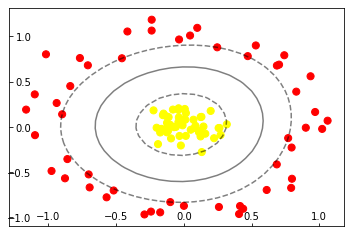

In [96]:
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.datasets.samples_generator import make_circles

X, y = make_circles(100, factor=.1, noise=.1)
clf = SVC(kernel='rbf', C=1E6, gamma='auto')
clf.fit(X, y)

fig = plt.figure()
ax = fig.gca()
ax.tick_params(axis="y",direction="in", pad=-22)
ax.tick_params(axis="x",direction="in", pad=-15)
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, ax);
#fig.tight_layout()
#plt.subplots_adjust(left=0.0, right=0.0, top=0.0, bottom=0.0)

In [98]:
import matplotlib.pyplot as plt
import io
import numpy as np

#x = np.arange(0,np.pi*3,.1)
#y = np.sin(x)

#plt.ioff()
#fig = plt.figure()
#plt.plot(x,y);


import base64
buf = io.BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
buf.close()
svg_data = ''.join(imgdata.readlines()) # this is svg data

plt.close(fig)


import json

def invoke():
  return IPython.display.JSON({'image': image_base64})


import IPython
from google.colab import output

main_str = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var classAbtn = [650, 100];
    var classBbtn = [650, 200];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos, cls) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = (cls == 0 ? 'rgba(200, 0, 0, 0.5)' : 'rgba(0, 0, 200, 0.5)');
      ctx.fill();
    }
    
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText('class A', 700, 100);
        ctx.fillText('class B', 700, 200);
        ctx.fillText(debug_txt, 200, 200);
        circ(ctx, classAbtn, 0);
        circ(ctx, classBbtn, 1);
        ctx.strokeRect(625, 75, 150, 50);
        ctx.strokeRect(625, 175, 150, 50);
        
        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]], active_pt[2]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]], item[2]);
        });
        
        
        
      }
    }
    
    var timer
    function init() {
      timer = setInterval(draw, 10);
    }
    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      if (is_close([x,y], classAbtn)) {
        active_pt = [x, y, 0]
      }
      if (is_close([x,y], classBbtn)) {
        active_pt = [x, y, 1]
      }
      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx > -1) {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
    }
    
    function mmove_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    async function calculate() {
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [], {});
      params = result.data['application/json'];
      bg_image.src = 'data:image/  png;base64,' + params.image;
    }
  </script>
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:275px; left:625px;">
    <button type="button" onclick="calculate();">
      Invoke SVM
    </button>
  </div>
  <script> init();</script>
'''



def generate_html():
  s = main_str
  return s
  
display(IPython.display.HTML(generate_html()))
    
    
output.register_callback('notebook.InvSVM', invoke)